In [1]:
######################
## General packages ##
######################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
#################################
## Load visualization packages ##
#################################

from covid19_DTM.visualization.output import color_timeframes
from covid19_DTM.visualization.output import color_timeframes
from covid19_DTM.visualization.output import _apply_tick_locator 
from covid19_DTM.models.utils import output_to_visuals, add_negative_binomial

In [3]:
################################
## Define simulation settings ##
################################

# Number of cores to use for the simulations
processes = 9
# Number of simulations for structural uncertainty
N = 4*processes
# End of simulation
end_sim = '2021-09-01'
# Confidence level used to visualise model fit
conf_int = 0.05
start_scenarios = '2021-03-01'
# Start of relaxations
start_relaxations=['2021-03-01','2021-04-01','2021-05-01','2021-06-01']

## National model

In [4]:
##################################
## Import the necessary modules ##
##################################

from covid19_DTM.data import sciensano
from covid19_DTM.models.utils import load_samples_dict
from covid19_DTM.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc

################################
## Define simulation settings ##
################################

# Spatial aggregation
agg = 'national'
# Number of age groups
age_stratification_size = 10
# BASE dictionary name
filename = 'national_REF_SAMPLES_2023-06-09.json'

#############################
## Load samples dictionary ##
#############################

# Path where MCMC samples were saved
samples_path = '../../../data/covid19_DTM/interim/model_parameters/calibrations/'+agg+'/'
samples_dict_nat = load_samples_dict(samples_path+str(filename), age_stratification_size=age_stratification_size)
# Extract tau-leap size and dispersion
tau_nat = float(samples_dict_nat['tau'])
dispersion = float(samples_dict_nat['dispersion'])
# Start of calibration warmup and beta
start_calibration = samples_dict_nat['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict_nat['end_calibration']

##################################################
## Load data not needed to initialize the model ##
##################################################

# Hospitalisation data
df_hosp, df_mort, df_cases, df_vacc = sciensano.get_sciensano_COVID19_data(update=False)
# Serodata
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()

##########################
## Initialize the model ##
##########################

model_nat, base_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size,
                                                                        update_data=False, start_date=start_calibration,
                                                                        stochastic=True)

#######################
## Sampling function ##
#######################

from covid19_DTM.models.draw_functions import draw_fnc_COVID19_SEIQRD_hybrid_vacc as draw_fnc_national

## Provincial spatial model

In [5]:
from covid19_DTM.models.utils import initialize_COVID19_SEIQRD_spatial_hybrid_vacc

################################
## Define simulation settings ##
################################

# Spatial aggregation
agg = 'prov'
# Number of age groups
age_stratification_size = 10
# BASE dictionary name
filename = 'prov_REF_SAMPLES_2023-06-14.json'

#############################
## Load samples dictionary ##
#############################

# Path where MCMC samples should be saved
samples_path = '../../../data/covid19_DTM/interim/model_parameters/calibrations/'+agg+'/'
samples_dict_prov = load_samples_dict(samples_path+str(filename), age_stratification_size=age_stratification_size)
# Extract tau-leap size and dispersion
tau_prov = float(samples_dict_prov['tau'])
dispersion = float(samples_dict_prov['dispersion'])
# Start of calibration warmup and beta
start_calibration = samples_dict_prov['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict_prov['end_calibration']

##########################
## Initialize the model ##
##########################

model_prov, base_samples_dict, initN = initialize_COVID19_SEIQRD_spatial_hybrid_vacc(age_stratification_size=age_stratification_size,
                                                                                agg=agg, update_data=False, start_date=start_calibration,
                                                                                stochastic=True)
#######################
## Sampling function ##
#######################

from covid19_DTM.models.draw_functions import draw_fnc_COVID19_SEIQRD_spatial_hybrid_vacc as draw_fnc_spatial

## Arrondissement spatial model

In [6]:
##################################
## Import the necessary modules ##
##################################

from covid19_DTM.models.utils import initialize_COVID19_SEIQRD_spatial_hybrid_vacc

################################
## Define simulation settings ##
################################

# Spatial aggregation
agg = 'arr'
# Number of age groups
age_stratification_size = 10
# BASE dictionary name
filename = 'arr_REF_SAMPLES_2023-06-14.json'
        
#############################
## Load samples dictionary ##
#############################

# Path where MCMC samples should be saved
samples_path = '../../../data/covid19_DTM/interim/model_parameters/calibrations/'+agg+'/'
samples_dict_arr = load_samples_dict(samples_path+str(filename), age_stratification_size=age_stratification_size)
# Extract tau-leap size and dispersion
tau_arr = float(samples_dict_arr['tau'])
dispersion = float(samples_dict_arr['dispersion'])
# Start of calibration warmup and beta
start_calibration = samples_dict_arr['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict_arr['end_calibration']

##########################
## Initialize the model ##
##########################

model_arr, base_samples_dict, initN = initialize_COVID19_SEIQRD_spatial_hybrid_vacc(age_stratification_size=age_stratification_size,
                                                                                agg=agg, update_data=False, start_date=start_calibration,
                                                                                stochastic=True)

## Simulate scenarios

In [11]:
print('\nNational model\n')

out_nat = []
for start_relaxation in start_relaxations:
    print(f'\tCurrently at relaxation date: {start_relaxation}\n')
    # Set parameters
    model_nat.parameters['start_relaxation'] = start_relaxation
    # Simulate
    out = model_nat.sim([start_calibration,end_sim], N=N, tau=tau_nat, processes=processes,
                         draw_function=draw_fnc_national,samples=samples_dict_nat)
    # Reduce dimensions
    tmp_out = out
    for dimension in out.dims:
        if ((dimension != 'date')&(dimension != 'draws')):
            tmp_out = tmp_out.sum(dim=dimension)
    out_nat.append(tmp_out)


National model

	Currently at relaxation date: 2021-03-01

	Currently at relaxation date: 2021-04-01

	Currently at relaxation date: 2021-05-01

	Currently at relaxation date: 2021-06-01



In [10]:
out_prov = []
print('\nProvincial model\n')
for start_relaxation in start_relaxations:
    print(f'\tCurrently at relaxation date: {start_relaxation}\n')
    # Set parameters
    model_prov.parameters['start_relaxation'] = start_relaxation
    # Simulate
    out = model_prov.sim([start_calibration,end_sim], N=N, tau=tau_prov, processes=processes,
                         draw_function=draw_fnc_spatial,samples=samples_dict_prov)
    # Reduce dimensions
    tmp_out = out
    for dimension in out.dims:
        if ((dimension != 'date')&(dimension != 'draws')):
            tmp_out = tmp_out.sum(dim=dimension)
    out_prov.append(tmp_out)


Provincial model

	Currently at relaxation date: 2021-03-01

	Currently at relaxation date: 2021-04-01

	Currently at relaxation date: 2021-05-01

	Currently at relaxation date: 2021-06-01



In [9]:
out_arr = []
print('\nArrondissement model\n')
for start_relaxation in start_relaxations:
    print(f'\tCurrently at relaxation date: {start_relaxation}\n')
    # Set parameters
    model_arr.parameters['start_relaxation'] = start_relaxation
    # Simulate
    out = model_arr.sim([start_calibration,end_sim], N=N, tau=tau_arr, processes=processes,
                         draw_function=draw_fnc_spatial,samples=samples_dict_arr)
    # Reduce dimensions
    tmp_out = out
    for dimension in out.dims:
        if ((dimension != 'date')&(dimension != 'draws')):
            tmp_out = tmp_out.sum(dim=dimension)
    out_arr.append(tmp_out)    


Arrondissement model

	Currently at relaxation date: 2021-03-01

	Currently at relaxation date: 2021-04-01

	Currently at relaxation date: 2021-05-01

	Currently at relaxation date: 2021-06-01



## Compute contacts: national model

In [12]:
# Import time-dependent parameter functions for resp. P, Nc, alpha, N_vacc, season_factor
from covid19_DTM.models.TDPF import  make_contact_matrix_function
# Import packages containing functions to load in data used in the model and the time-dependent parameter functions
from covid19_DTM.data import mobility, model_parameters
start_visualization = '2020-09-01'
end_visualization = '2021-09-01'
dates = pd.date_range(start=start_visualization, end=end_visualization)

In [ ]:
# df_google = mobility.get_google_mobility_data(update=False)
# Nc_dict, params, samples_dict, initN = model_parameters.get_model_parameters()

In [ ]:
# policy_function_normal = make_contact_matrix_function(df_google, Nc_dict).policies_all

# c=[]
# for date in dates:
#     c.append(np.mean(np.sum(policy_function_normal(date ,{'H_in': out_nat[-1]['H_in'].sel(date=date).mean(dim='draws').values}, {},
#                                 model_nat.parameters['l1'],
#                                 model_nat.parameters['l2'],                     
#                                 np.mean(samples_dict_nat['eff_work']),
#                                 np.mean(samples_dict_nat['eff_work']),
#                                 np.mean(samples_dict_nat['eff_work']),  
#                                 model_nat.parameters['eff_home'],  
#                                 np.mean(samples_dict_nat['mentality']),
#                                 0),axis=1)))
# contacts_normal_nat = pd.Series(index=dates, data=c)

In [ ]:
# policy_function_scenarios = make_contact_matrix_function(df_google, Nc_dict).policies_all_manuscript

# contacts_nat=[]
# for i,start_relaxation in enumerate(start_relaxations):
#     c=[]
#     for date in dates:
#         c.append(np.mean(np.sum(policy_function_scenarios(date ,{'H_in': out_nat[i]['H_in'].sel(date=date).mean(dim='draws').values}, {},
#                                 model_nat.parameters['l1'],
#                                 model_nat.parameters['l2'],                     
#                                 np.mean(samples_dict_nat['eff_work']),
#                                 np.mean(samples_dict_nat['eff_work']),
#                                 np.mean(samples_dict_nat['eff_work']),  
#                                 model_nat.parameters['eff_home'],                         
#                                 np.mean(samples_dict_nat['mentality']),
#                                 0,                            
#                                 start_relaxation),axis=1)))
#     contacts_nat.append(pd.Series(index=dates, data=c))

In [ ]:
# ##############
# ## Settings ##
# ##############


# scenario_colors = ['maroon', 'blue', 'olive', 'black']
# scenario_linestyles=['-',':','-.','--']
# legend_text=['S0', 'S1', 'S2', 'S3']
# #scatter_size = 10
# #alpha_scatter = 1

# fig, ax = plt.subplots(figsize=(15,3))

# ###################
# ## Plot contacts ##
# ###################

# for i in range(len(start_relaxations)):
#     ax.plot(contacts_nat[i][start_scenarios:], color=scenario_colors[i], linestyle=scenario_linestyles[i])
# ax.legend(legend_text, loc=9, ncol=2, framealpha=1)
# ax.plot(contacts_normal_nat[:start_scenarios], color='gray')

# ########################
# ## Plot vertical line ##
# ########################

# ax.axvline(x=pd.Timestamp('2021-03-01'), color='k', linestyle='--', linewidth=1)

# ################
# ## Background ##
# ################

# start_background = pd.Timestamp(2020, 1, 1)
# week_color='white'
# weekend_color='white'
# vacation_color='lightgrey'
# color_timeframes(start_background, end_sim, ax=ax, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

# ###################
# ## Format figure ##
# ###################

# ax.set_xlim([pd.Timestamp(start_visualization), pd.Timestamp(end_visualization)])
# ax.grid(False)
# ax.set_ylabel('No. Social contacts')
# ax.set_ylim([0,20])

# plt.savefig(f"four_projected_Nc_1mar2021.pdf", bbox_inches='tight')

## Visualise contacts provincial model

In [ ]:
# df_google = mobility.get_google_mobility_data(update=False, provincial=True)
# Nc_dict, params, samples_dict, initN = model_parameters.get_model_parameters(agg='prov')
# policy_function_scenarios = make_contact_matrix_function(df_google, Nc_dict, G=11).policies_all_spatial_manuscript
# policy_function_normal = make_contact_matrix_function(df_google, Nc_dict, G=11).policies_all_spatial

In [ ]:
# c=[]
# for date in dates:
#     c.append(np.mean(np.sum(policy_function_normal(date ,{'H_in': out_prov[-1]['H_in'].sel(date=date).mean(dim='draws').values}, {},
#                                 model_prov.parameters['l1'],
#                                 model_prov.parameters['l2'],                     
#                                 np.mean(samples_dict_prov['eff_work']),
#                                 np.mean(samples_dict_prov['eff_work']),
#                                 np.mean(samples_dict_prov['eff_work']),  
#                                 model_prov.parameters['eff_home'],                         
#                                 np.mean(samples_dict_prov['mentality']),
#                                 0, #np.mean(samples_dict_prov['k']),  
#                                 np.mean(samples_dict_prov['summer_rescaling_F']), 
#                                 np.mean(samples_dict_prov['summer_rescaling_W']),
#                                 np.mean(samples_dict_prov['summer_rescaling_B'])),axis=1)))    
# contacts_normal_prov = pd.Series(index=dates, data=c)

In [ ]:
# contacts_prov=[]
# for i,start_relaxation in enumerate(start_relaxations):
#     c=[]
#     for date in dates:
#         c.append(np.mean(np.sum(policy_function_scenarios(date ,{'H_in': out_prov[i]['H_in'].sel(date=date).mean(dim='draws').values}, {},
#                                 model_prov.parameters['l1'],
#                                 model_prov.parameters['l2'],                     
#                                 np.mean(samples_dict_prov['eff_work']),
#                                 np.mean(samples_dict_prov['eff_work']),
#                                 np.mean(samples_dict_prov['eff_work']),  
#                                 model_prov.parameters['eff_home'],                         
#                                 np.mean(samples_dict_prov['mentality']),
#                                 0, #np.mean(samples_dict_prov['k']),  
#                                 np.mean(samples_dict_prov['summer_rescaling_F']), 
#                                 np.mean(samples_dict_prov['summer_rescaling_W']),
#                                 np.mean(samples_dict_prov['summer_rescaling_B']),                       
#                                 start_relaxation),axis=1)))
#     contacts_prov.append(pd.Series(index=dates, data=c))

In [ ]:
# ##############
# ## Settings ##
# ##############

# start_scenarios = '2021-03-01'
# scenario_colors = ['maroon', 'blue', 'olive', 'black']
# scenario_linestyles=['-',':','-.','--']
# legend_text=['S0', 'S1', 'S2', 'S3']
# #scatter_size = 10
# #alpha_scatter = 1

# fig, ax = plt.subplots(figsize=(15,3))

# ###################
# ## Plot contacts ##
# ###################

# for i in range(len(start_relaxations)):
#     ax.plot(contacts_prov[i][start_scenarios:], color=scenario_colors[i], linestyle=scenario_linestyles[i])
# ax.legend(legend_text, loc=9, ncol=2, framealpha=1)
# ax.plot(contacts_normal_prov[:start_scenarios], color='gray')

# ########################
# ## Plot vertical line ##
# ########################

# ax.axvline(x=pd.Timestamp('2021-03-01'), color='k', linestyle='--', linewidth=1)

# ################
# ## Background ##
# ################

# start_background = pd.Timestamp(2020, 1, 1)
# week_color='white'#'white'
# weekend_color='white'#'lightgrey'
# vacation_color='lightgrey'#weekend_color
# color_timeframes(start_background, end_sim, ax=ax, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

# ###################
# ## Format figure ##
# ###################

# ax.set_xlim([pd.Timestamp(start_visualization), pd.Timestamp(end_visualization)])
# ax.grid(False)
# ax.set_ylabel('No. Social contacts')
# ax.set_ylim([0,20])

# plt.savefig(f"four_projected_Nc_1mar2021.pdf", bbox_inches='tight')

## Visualize scenarios

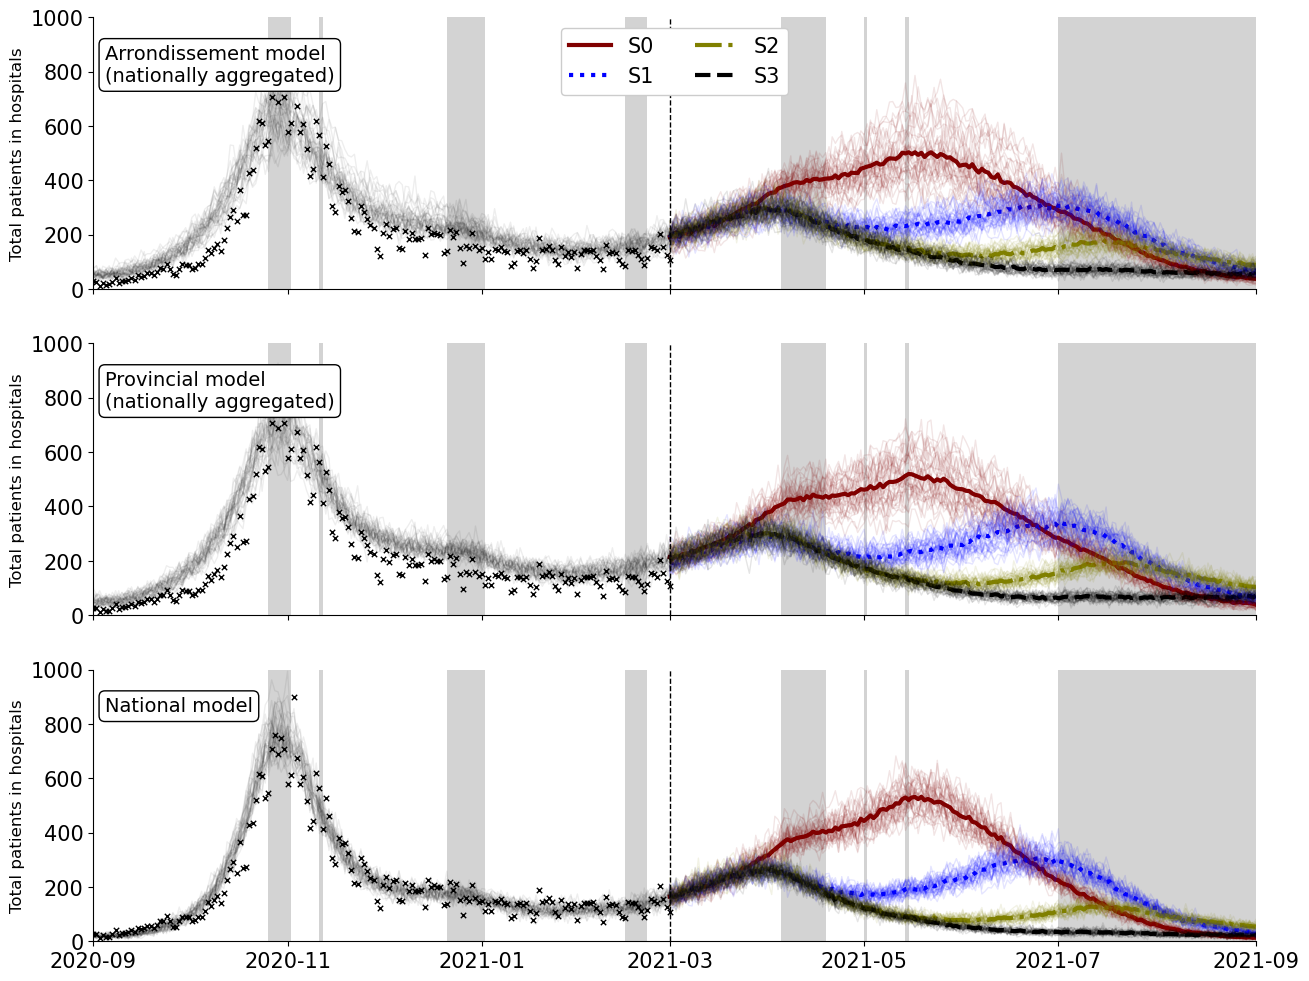

In [16]:
# Select state
state = 'H_in'
y_data = df_hosp[state].groupby(by='date').sum()[:start_scenarios]
x_data = y_data.index
axes_label = 'Total patients in hospitals'
# Group output
output = [out_arr, out_prov, out_nat]
titles = ['Arrondissement model\n(nationally aggregated)', 
          'Provincial model\n(nationally aggregated)',
          'National model']   

#######################
## Visualize results ##
#######################

start_visualization = '2020-09-01'
end_visualization = '2021-09-01'
start_scenarios = '2021-03-01'

scenario_linestyles=['-',':','-.','--']
legend_text=['S0', 'S1', 'S2', 'S3']
scatter_size = 15
alpha_scatter = 1
# Model prediction properties
linewidth=1
alpha_structural=0.10
scenario_colors = ['maroon', 'blue', 'olive', 'black']

fig, ax = plt.subplots(nrows=len(output), ncols=1, figsize=(15,(8/2)*len(output)), sharex=True)


for k,out in enumerate(output):
    
    x_model = out[0].date.values

    #########################
    ## Loop over scenarios ##
    #########################

    for i in range(len(start_relaxations)):
        ax[k].plot(out[i][state].mean(dim='draws').sel(date=slice(start_scenarios, None))['date'].values,
                    out[i][state].mean(dim='draws').sel(date=slice(start_scenarios, None)), color=scenario_colors[i],
                    alpha=1, linestyle=scenario_linestyles[i])
        if k == 0:
            ax[k].legend(legend_text, loc=9, ncol=2, framealpha=1)

    for i in range(len(start_relaxations)):
        for j in range(1,N):
            ax[k].plot(out[i][state].isel(draws=j).sel(date=slice(start_scenarios, None))['date'].values,
                    out[i][state].isel(draws=j).sel(date=slice(start_scenarios, None)), color=scenario_colors[i],
                    linewidth=linewidth, alpha=alpha_structural)

    ################################################
    ## Plot one model prediction until March 30th ##
    ################################################

    for i in range(N):
        ax[k].plot(out[0][state].isel(draws=i).sel(date=slice(None, start_scenarios))['date'].values,
                out[0][state].isel(draws=i).sel(date=slice(None, start_scenarios)), color='black',
                linewidth=linewidth, alpha=alpha_structural/1.5)

    ########################
    ## Plot national data ##
    ########################

    ax[k].scatter(x_data, y_data, s=scatter_size, color='k', marker='x', linewidth=1, alpha=alpha_scatter)

    ########################
    ## Plot vertical line ##
    ########################

    ax[k].axvline(x=pd.Timestamp('2021-03-01'), color='k', linestyle='--', linewidth=1)

    ################
    ## Background ##
    ################

    start_background = pd.Timestamp(2020, 1, 1)
    week_color='white'
    weekend_color='white'
    vacation_color='lightgrey'
    color_timeframes(start_background, end_sim, ax=ax[k], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

    ###################
    ## Format figure ##
    ###################

    ax[k].set_xlim([pd.Timestamp(start_visualization), pd.Timestamp(end_visualization)])
    ax[k].set_ylim([0, 1000])
    ax[k].grid(False)
    ax[k].set_ylabel(axes_label, fontsize=12)
    
    ##############
    ## Text box ##
    ##############

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    # place a text box in upper left in axes coords
    ax[k].text(0.01, 0.90, titles[k], transform=ax[k].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    if state == 'H_tot':

        #ax[k].axhline(y=5000, color='maroon', linewidth=2)
        #ax[k].axhline(y=10000, color='maroon', linewidth=2)
    
        ax[k].set_ylim([-10, 15000])
        ax_2 = ax[k].twinx()
        ax_2.set_ylim([-10/5, 15000/5])
        ax_2.set_yticks([0,1000,2000,3000])
        ax_2.set_yticks([0,1000,2000, 3000])
        ax_2.set_ylabel('Total IC patients', fontsize=12)
        ax_2.grid(False)
        
###################
## Plot contacts ##
###################

#ax[2].plot(contacts_normal[:start_scenarios], color='gray')
#for i in range(len(start_relaxations)):
#    ax[2].plot(contacts[i][start_scenarios:], color=scenario_colors[i], linestyle=scenario_linestyles[i])
#ax[2].set_ylabel('No. contacts', fontsize=12)

plt.savefig(f"four_projected_scenarios_1mar2021_{state}.pdf", bbox_inches='tight')